# Limpieza de Datos Locales 20190712

In [33]:
import pandas as pd
from utils import  upload_to_bucket

# Importar Datasets

In [34]:
locales_col_names = [
    'id_cadena', 'desc_cadena', 'id_region', 'desc_region', 'idb',
    'desc_local', 'latitud', 'longitud', 'punto_dist'
]

dtypes = {
    'desc_region': 'string',
    'desc_local': 'string',
    'punto_dist': 'string',
}

In [35]:
locales_df = pd.read_csv("../data/Locales.txt",
                         encoding="UTF-8",
                         header=None,
                         delimiter='\t',
                         names=locales_col_names,
                         dtype=dtypes)

In [36]:
locales_df.head()


,id_cadena,desc_cadena,id_region,desc_region,idb,desc_local,latitud,longitud,punto_dist
0,1,Plaza Vea,1,Buenos Aires,9693,9693 - P Vea Villa Urquiza.,NaN,NaN,N
1,1,Plaza Vea,1,Buenos Aires,9694,9694 - P Vea JB Justo.,NaN,NaN,N
2,1,Plaza Vea,1,Buenos Aires,9695,695 - P Vea Acoyte.,0.0,0.0,N
3,1,Plaza Vea,1,Buenos Aires,9699,699 - P Vea Rivadavia.,0.0,0.0,N
4,1,Plaza Vea,1,Buenos Aires,9889,889 - Plaza Vea Carpa de liqui,NaN,NaN,N


In [37]:
locales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_cadena    175 non-null    int64  
 1   desc_cadena  175 non-null    object 
 2   id_region    175 non-null    int64  
 3   desc_region  175 non-null    string 
 4   idb          175 non-null    int64  
 5   desc_local   175 non-null    string 
 6   latitud      140 non-null    float64
 7   longitud     140 non-null    float64
 8   punto_dist   175 non-null    string 
dtypes: float64(2), int64(3), object(1), string(3)
memory usage: 12.4+ KB


#### Ajustes al dataframe

- Eliminar la columna "desc_local" debido a que no aporta información relevante para el análisis y se dispone de las coordenadas.
- Convertir todas las cadenas de texto en minúsculas para unificar la información y facilitar su procesamiento.
- Verificar si existen valores nulos o duplicados en el conjunto de datos para asegurar la integridad de la información y decidir cómo manejarlos si es necesario.
- Convertir la columna categórica "punto_dist" a una variable binaria con la siguiente regla: asignar 1 a las observaciones en las que el valor de la columna sea "s", lo que indica que es un punto de distribución, y asignar 0 a todas las demás observaciones.
- Crear una nueva columna llamada "local" usando la columna "punto_dist" de la siguiente manera: si "punto_dist" es 1, entonces la observación es un local y "local" se establece en 1; de lo contrario, "local" se establece en 0.
- Rellenar los valores "NaN" de latitud y longitud con la media de sus respectivas columnas. Esto permitirá mantener la integridad del conjunto de datos y evitar problemas en el procesamiento posterior.
- Identificar las observaciones con valores 0.00 en las columnas de latitud y longitud. Esto puede indicar datos faltantes o imprecisos, por lo que es necesario revisar estos casos y tomar las medidas adecuadas, como la eliminación o la imputación de valores.


In [38]:
locales_df.drop('desc_local', axis=1, inplace=True)

In [39]:
locales_df = locales_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [40]:
print(locales_df.isna().sum())

id_cadena       0
desc_cadena     0
id_region       0
desc_region     0
idb             0
latitud        35
longitud       35
punto_dist      0
dtype: int64


In [41]:
locales_df.isnull().sum(axis=0)

id_cadena       0
desc_cadena     0
id_region       0
desc_region     0
idb             0
latitud        35
longitud       35
punto_dist      0
dtype: int64

In [42]:
# Convertir la columna categorica punto_dist a binaria
punto_dist_mapping = {"s": 1, "n": 0}
locales_df['punto_dist'] = locales_df['punto_dist'].map(punto_dist_mapping)

In [43]:
# Crear una columna binaria para identificar si es un local
locales_df['local'] = locales_df['punto_dist'].apply(lambda x: 1 if x == 0 else 0)

In [44]:
# Identify the duplicate rows using a subset of columns
subset_cols = ['idb', 'id_cadena']
duplicate_mask = locales_df.duplicated(subset=subset_cols, keep='first')

# Count the number of duplicate rows
total_duplicates = sum(duplicate_mask)

print(f"El total de registros duplicados en el dataset es: {total_duplicates}")

El total de registros duplicados en el dataset es: 0


In [45]:
# Conteo de los niveles en las diferentes columnas categóricas
col_categoricas = ['desc_cadena', 'desc_region']
for col in col_categoricas:
    print(f'La columna categorica {col} tiene {locales_df[col].nunique()} subnivele(s)')

La columna categorica desc_cadena tiene 5 subnivele(s)
La columna categorica desc_region tiene 1 subnivele(s)


In [15]:
coordinates = pd.read_csv('../data/coordinates.csv', encoding='utf-8', delimiter='\t')

In [16]:
# merge the two dataframes on the key column
merged_df = pd.merge(locales_df, coordinates, on='idb', suffixes=('', '_right'))

# use boolean indexing to replace zero values with values from the second dataframe
merged_df.loc[merged_df['latitud'] == 0.0, 'latitud'] = merged_df['latitud_right']
merged_df.loc[merged_df['longitud'] == 0.0, 'longitud'] = merged_df['longitud_right']

#drop the extra column
merged_df.drop(['longitud_right', 'latitud_right'], axis=1, inplace=True)

In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_cadena    14 non-null     int64  
 1   desc_cadena  14 non-null     object 
 2   id_region    14 non-null     int64  
 3   desc_region  14 non-null     object 
 4   idb          14 non-null     int64  
 5   latitud      14 non-null     float64
 6   longitud     14 non-null     float64
 7   punto_dist   14 non-null     int64  
 8   local        14 non-null     int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 1.1+ KB


In [18]:
locales_df.set_index('idb', inplace=True)
locales_df.update(merged_df.set_index('idb'))
locales_df.reset_index(inplace=True)
locales_df = locales_df.astype({'idb': 'int64', 'punto_dist': 'int64', 'id_cadena': 'int64', 'id_region': 'int64', 'desc_cadena':'string', 'desc_region':'string', 'local':'int64' })

In [19]:
# Llenar los valores missing de latitud y longitud con la media de cada columna.
mean_latitud = locales_df['latitud'].mean()
mean_longitud = locales_df['longitud'].mean()
locales_df['latitud'].fillna(mean_latitud, inplace=True)
locales_df['longitud'].fillna(mean_longitud, inplace=True)

In [20]:
# Verificar que no existan valores missing o 0.0 para las columnas latitud y longitud.
print(len(locales_df[(locales_df['latitud'] == 0.0) | (locales_df['longitud'] == 0.0)]))
print(locales_df[['longitud','latitud']].isna().sum(axis=0))

0
longitud    0
latitud     0
dtype: int64


In [46]:
grouped_data = locales_df.groupby(['id_cadena', 'desc_cadena']).idb.count()
grouped_data_percent = locales_df.groupby(['id_cadena', 'desc_cadena'])['idb'].count() / locales_df['idb'].count() * 100
grouped_data_percent.index = grouped_data_percent.index.map(lambda x: (str(x[0]).strip(), str(x[1]).strip()))
grouped_data_percent = grouped_data_percent.reset_index().set_index(['id_cadena', 'desc_cadena'])
grouped_data_percent

,,idb
id_cadena,desc_cadena,
1,plaza vea,2.857143
2,disco,34.857143
4,vea,38.857143
9,jumbo,17.714286
11,rincon jumbo,5.714286


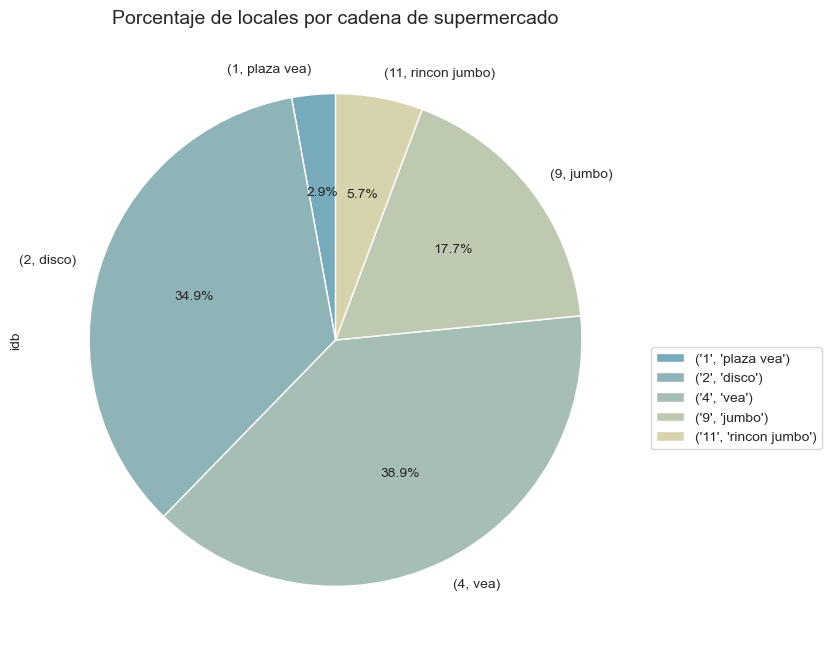

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and color palette
sns.set_style("whitegrid")
color = "blend:#7AB,#EDA"
sns.set_palette(sns.color_palette(color))

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
grouped_data_percent.plot(kind='pie', y='idb', ax=ax, autopct='%1.1f%%', startangle=90, shadow=False, legend=False)

# Add title and legend
ax.set_title('Porcentaje de locales por cadena de supermercado', fontsize=14)
ax.legend(grouped_data_percent.index, loc='upper left', bbox_to_anchor=(1.0, 0.5))

# Save the plot as an image file
plt.savefig(f'../eda/images/porcentaje_locales.png', dpi=300, bbox_inches='tight')

plt.show()


In [51]:
grouped_data_pd = locales_df.groupby(['local', 'punto_dist', 'desc_cadena']).idb.count()
grouped_data_pd

local  punto_dist  desc_cadena                   
0      1           disco                              3
                   jumbo                              3
1      0           disco                             58
                   jumbo                             28
                   plaza vea                          5
                   rincon jumbo                      10
                   vea                               68
Name: idb, dtype: int64

In [52]:
locales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_cadena    175 non-null    int64  
 1   desc_cadena  175 non-null    object 
 2   id_region    175 non-null    int64  
 3   desc_region  175 non-null    object 
 4   idb          175 non-null    int64  
 5   latitud      140 non-null    float64
 6   longitud     140 non-null    float64
 7   punto_dist   175 non-null    int64  
 8   local        175 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 12.4+ KB


In [56]:
locales_df.shape

(140, 9)

In [54]:
locales_df.describe()

,id_cadena,id_region,idb,latitud,longitud,punto_dist,local
count,175.000000,175.0,175.000000,140.000000,140.000000,175.000000,175.000000
mean,4.502857,1.0,6909.617143,-31.533832,-52.839588,0.034286,0.965714
std,2.945627,0.0,3421.539461,10.718891,17.724343,0.182484,0.182484
min,1.000000,1.0,242.000000,-45.872649,-67.496036,0.000000,0.000000
25%,2.000000,1.0,5213.500000,-34.730633,-58.632039,0.000000,1.000000
50%,4.000000,1.0,9019.000000,-34.601654,-58.434434,0.000000,1.000000
75%,4.000000,1.0,9158.500000,-34.546212,-58.251974,0.000000,1.000000
max,11.000000,1.0,9977.000000,0.000000,0.000000,1.000000,1.000000


#### Observaciones
1. El conjunto de datos está compuesto por 175 registros y 9 columnas. Las columnas son: "id_cadena", "desc_cadena", "id_region", "desc_region", "idb", "latitud", "longitud", "punto_distr" y "local". Estas columnas se describen a continuación:

    - id_cadena: Identificador interno de la cadena.
    - desc_cadena: Descripción de la cadena.
    - id_region: Identificador interno de la región.
    - desc_region: Descripción de la región.
    - idb: Identificador interno de la boca.
    - latitud: Ubicación en el eje Y de la boca.
    - longitud: Ubicación en el eje X de la boca.
    - punto_distr: Indica si el valor es 1 que es un centro de distribución, de lo contrario es un local.
    - local: Indica si el valor es 1 que es un local, si es 0 no es un local.

2. Se ha eliminado la columna "desc_local" debido a que no aporta información relevante para el análisis y se dispone de las coordenadas de latitud y longitud.

3. Se encontraron 35 valores de latitud y longitud que contenían valores nulos y 14 registros con valores en 0.0. Para los valores nulos se rellenaron con el valor medio de las columnas de latitud y longitud, y para los registros con valores en 0.0 se encontraron los valores correspondientes de las coordenadas y se realizaron las imputaciones.

4. Se encontraron dos columnas categóricas con los siguientes subniveles:
    - La columna "desc_cadena" tiene 5 subniveles: Plaza Vea, Vea, Jumbo, Disco y Rinco Jumbo.
    - La columna "desc_region" tiene 1 subnivel, el cual es Buenos Aires.

5. Todos los registros de la columna "desc_region" tienen el valor "Buenos Aires", lo que indica que solo hay una región.

6. Se agruparon las categorías de la columna "desc_cadena" de la siguiente manera:

    | **Cadena** | **Total Locales** |
        Plaza Vea | 5
        Disco | 61
        Vea | 68
        Jumbo | 31
        Rincon Jumbo | 10

7. El conjunto de datos contiene 6 centros de distribución y 169 locales.




#### Guardar el dataset limpio

In [508]:
locales_df.to_csv('../clean_data/locales_clean.csv', index=False)

#### Subir csv a google cloud storage

In [509]:
upload_to_bucket('deodorants', '../clean_data/locales_clean.csv', 'locales')

File ../clean_data/locales_clean.csv uploaded successfully to bucket deodorants/locales
